In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import random
import pickle as pk
%matplotlib inline

models = ['ridge_cox', 'elastic_net_cox', 'random_survival_forest', 'gradient_boosting']

file_names_map = {
    'ridge_cox': 'model=(ridge_cox)_general_pp=(ohe_norm)_cf_pp=(bool)', 
    'elastic_net_cox': 'model=(elastic_net_cox)_general_pp=(ohe_norm)_cf_pp=(bool)', 
    'random_survival_forest': 'model=(random_survival_forest)_general_pp=(ohe_norm)_cf_pp=(bool)', 
    'gradient_boosting': 'model=(gradient_boosting)_general_pp=(ohe_norm)_cf_pp=(bool)', 
}

names_map = {
    'ridge_cox': "Ridge-Cox's\nPH", 
    'elastic_net_cox': "Elastic Net-Cox's\nPH", 
    'random_survival_forest': "Random Survival\nForest", 
    'gradient_boosting': "Gradient Boosting\nSurvival Analysis"
}

names_map_2 = {
    'ridge_cox': "Ridge-Cox's PH", 
    'elastic_net_cox': "Elastic Net-Cox's PH", 
    'random_survival_forest': "Random Survival Forest", 
    'gradient_boosting': "Gradient Boosting Survival Analysis"
}


In [2]:
def calculateMeanAUC(times, aucs): 
    times_result = []
    auc_result = []
    dicts = []
    for i in range(len(times)): 
        dict_time_auc = dict()
        for j in range(len(times[i])): 
            time = times[i][j]
            times_result.append(time)
            dict_time_auc[time] = aucs[i][j]
        dicts.append(dict_time_auc)
        
    times_result = list(set(times_result))
    times_result.sort()
    
    for tr in times_result: 
        auc_values = []
        for i in range(len(times)): 
            dict_time_auc = dicts[i]
            if tr in dict_time_auc: 
                auc_values.append(dict_time_auc[tr])
            elif any([t<tr for t in times[i]]): 
                t_previo = max([t for t in times[i] if t<tr])
                auc_values.append(dict_time_auc[t_previo])
        auc_result.append(sum(auc_values)/len(auc_values))
    
    return times_result, auc_result

In [3]:
from itertools import cycle

def showOverallComparison(models): 
    cindexes = []
    aucs = []
    briers = []

    for model in models: 
        scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
        cindexes.append(scores['cindex'])
        briers.append(scores['brier'])
        aucs.append(scores['mean_auc'])

    fig = plt.figure(figsize=(8, 2.5))

    xs = []
    for i,d in enumerate(cindexes): 
        xs.append(np.random.normal(i+1, 0.09, len(d)))
    alpha_points = 0.2

    #c-index 
    plt.subplot(1,3,1)
    for i, (x, d) in enumerate(zip(xs, cindexes[::-1])): 
        for axis, point in zip(x,d): 
            plt.scatter(point, axis, alpha=alpha_points, color='salmon')

    bp = plt.boxplot(cindexes, labels=[names_map[model] for model in models], showfliers=False, vert=False, positions=[4, 3, 2, 1])
    plt.setp(bp['medians'], color='black')

    plt.xlim([0.85, 1])
    plt.xticks(rotation=45)
    plt.ylabel("models")
    plt.xlabel('C-index')
    plt.grid(axis='x')

    #MEAN AUC
    plt.subplot(1,3,2)
    cycol = cycle('bgrcmk')
    for i, (x, d) in enumerate(zip(xs, aucs[::-1])): 
        for axis, point in zip(x,d): 
            plt.scatter(point, axis, alpha=alpha_points, color=next(cycol))

    bp = plt.boxplot(aucs, labels=[""]*len(models), showfliers=False, vert=False, positions=[4, 3, 2, 1])
    plt.setp(bp['medians'], color='black')
    plt.xlim([0.85, 1])
    plt.xticks(rotation=45)
    plt.xlabel('Mean time-dependent AUC')
    plt.grid(axis='x')

    #brier
    plt.subplot(1,3,3)
    for i, (x, d) in enumerate(zip(xs, briers[::-1])): 
        for axis, point in zip(x,d): 
            plt.scatter(point, axis, alpha=alpha_points, color='orange')

    bp = plt.boxplot(briers, labels=[""]*len(models), showfliers=False, vert=False, positions=[4, 3, 2, 1])
    plt.setp(bp['medians'], color='black')
    plt.xlim([0, 0.15])
    plt.xticks(rotation=45)
    plt.xlabel('Brier score')
    plt.grid(axis='x')

    fig.savefig(f'figs/comparison.pdf', bbox_inches='tight', format='pdf')

    #AUC
    fig = plt.figure(figsize=(9,9))
    cycol = cycle('bgrcmk')
    
    n_models = len(models)
    n_subplots = n_models+1

    for i, model in enumerate(models): 
        plt.subplot(int(n_subplots/2)+1, 2, i+1)
        scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
        
        times = scores['times']
        aucs = scores['auc']

        for (auc, time) in zip(aucs, times): 
            plt.plot(time, auc, marker='.', color=next(cycol), alpha=0.05)
            plt.ylim([0.83, 1.01])

        mean_times, mean_auc = calculateMeanAUC(times, aucs)
        mean_mean_auc = sum(mean_auc)/len(mean_auc)

        plt.plot(mean_times, mean_auc, marker='.', color='black')
        plt.axhline(mean_mean_auc, linestyle='--')
        plt.title(names_map_2[model])
        if i%2==0: 
            plt.ylabel('time-dependent AUC')
        if i>1: 
            plt.xlabel('days')
        plt.grid()
        
    fig.tight_layout()
    fig.savefig(f'figs/auc.pdf', bbox_inches='tight', format='pdf')


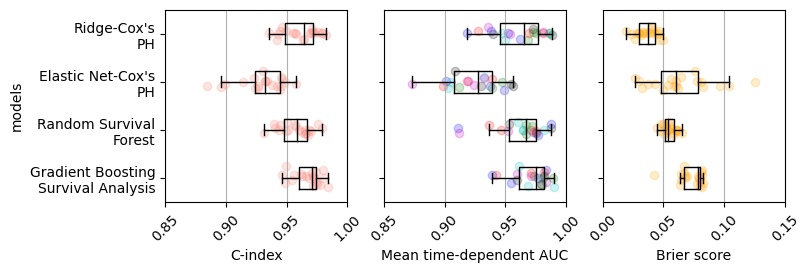

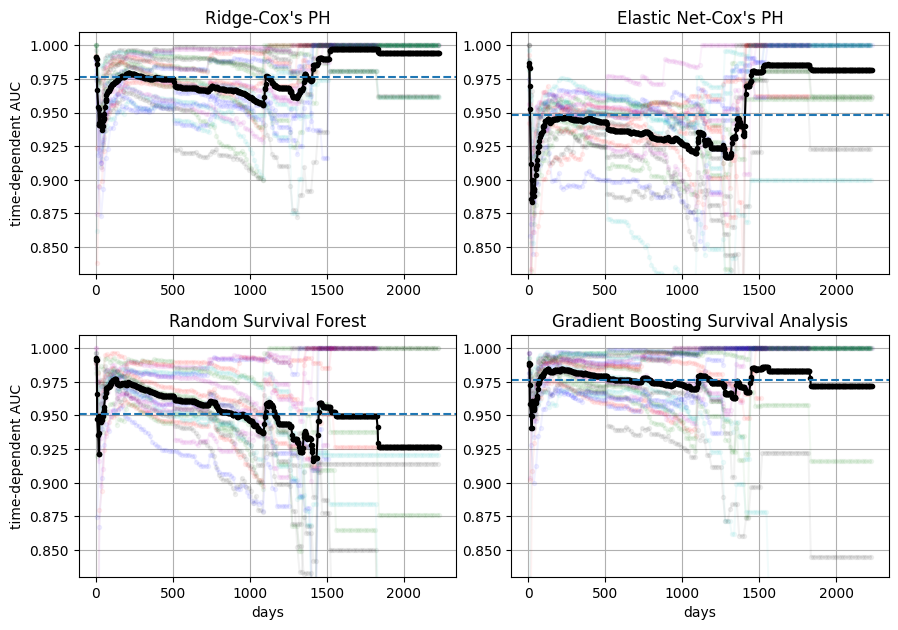

In [4]:
showOverallComparison(models)

In [7]:
def showCindexComparison(models): 
    cindexes = []
    
    for model in models: 
        scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
        cindexes.append(scores['cindex'])
        
    plt.figure(figsize=(3, 3))
        
    xs=[]
    for i, d in enumerate(cindexes): 
        xs.append(np.random.normal(i+1, 0.08, len(d)))  
        
    alpha_points = 0.2
    for i, (x, d) in enumerate(zip(xs, cindexes)): 
        for axis, point in zip(x, d): 
            plt.scatter(axis, point, alpha=alpha_points, color='green')
    
    bp = plt.boxplot(cindexes, labels=models, showfliers=False)
    plt.setp(bp['medians'], color='black', linestyle='--')
    
    plt.ylim([0.8, 1])
    plt.xticks(rotation=30, ha='right')
    plt.xlabel("models", size=14)
    plt.ylabel("C-index", size=14)
    plt.grid(axis='y')
    plt.show()

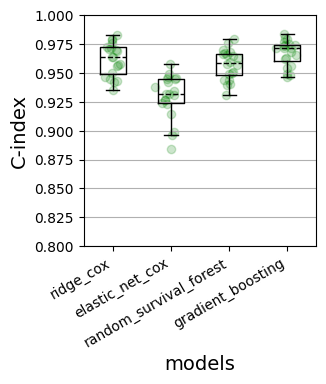

In [8]:
showCindexComparison(models)

In [9]:
def showBrierComparison(models): 
    brier_scores = []
    models_with_brier = []
    for model in models: 
        scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
        if len(scores['brier']) != 0:
            brier_scores.append(scores['brier'])
            models_with_brier.append(model)

    plt.figure(figsize=(3,3))

    xs=[]
    for i, d in enumerate(brier_scores): 
        xs.append(np.random.normal(i+1, 0.08, len(d)))  

    alpha_points = 0.2
    for i, (x, d) in enumerate(zip(xs, brier_scores)): 
        for axis, point in zip(x, d): 
            plt.scatter(axis, point, alpha=alpha_points, color='orange')

    bp = plt.boxplot(brier_scores, labels=models_with_brier, showfliers=False)
    plt.setp(bp['medians'], color='black', linestyle='--')

    plt.ylim([0, 0.3])
    plt.xticks(rotation=30, ha='right')
    plt.xlabel("models", size=14)
    plt.ylabel("Brier score", size=14)
    plt.grid(axis='y')
    plt.show()

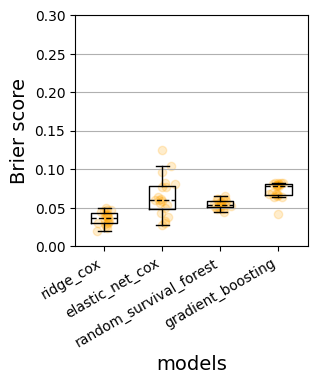

In [10]:
showBrierComparison(models)

In [11]:
def showAUC(models): 
    
    for model in models: 

        scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
        
        times = scores['times']
        auc = scores['auc']
        mean_auc = scores['mean_auc']

        print('\n#############################')
        print(f'MODEL: {model}')
        print('#############################\n')

        plt.figure(figsize=(10, 30))
        for i in range(len(times)): 
            plt.subplot(10, 3, i+1)
            plt.plot(times[i], auc[i], marker='o')
            plt.axhline(mean_auc[i], linestyle='--')
            if i in (27, 28, 29): 
                plt.xlabel('days from enrollment')
            if i%3==0: 
                plt.ylabel('time-dependent AUC')
            plt.xlim([-80, 2500])
            plt.ylim([0.83, 1.01])
            plt.grid(True)
            plt.title(f'Partition {i+1}', y=0.0, x=0.75, fontsize=10)
        plt.show()

        times_avg, auc_avg = calculateMeanAUC(times, auc)
        mean_auc_avg = sum(auc_avg)/len(auc_avg)
        fig, ax = plt.subplots()
        plt.plot(times_avg, auc_avg, marker="o")
        plt.axhline(mean_auc_avg, linestyle="--")
        plt.xlabel("days from enrollment")
        plt.ylabel("time-dependent AUC")
        plt.xlim([-80, 2500])
        plt.ylim([0.83, 1.01])
        plt.grid(True)
        plt.title("Average")
        plt.show()



#############################
MODEL: ridge_cox
#############################



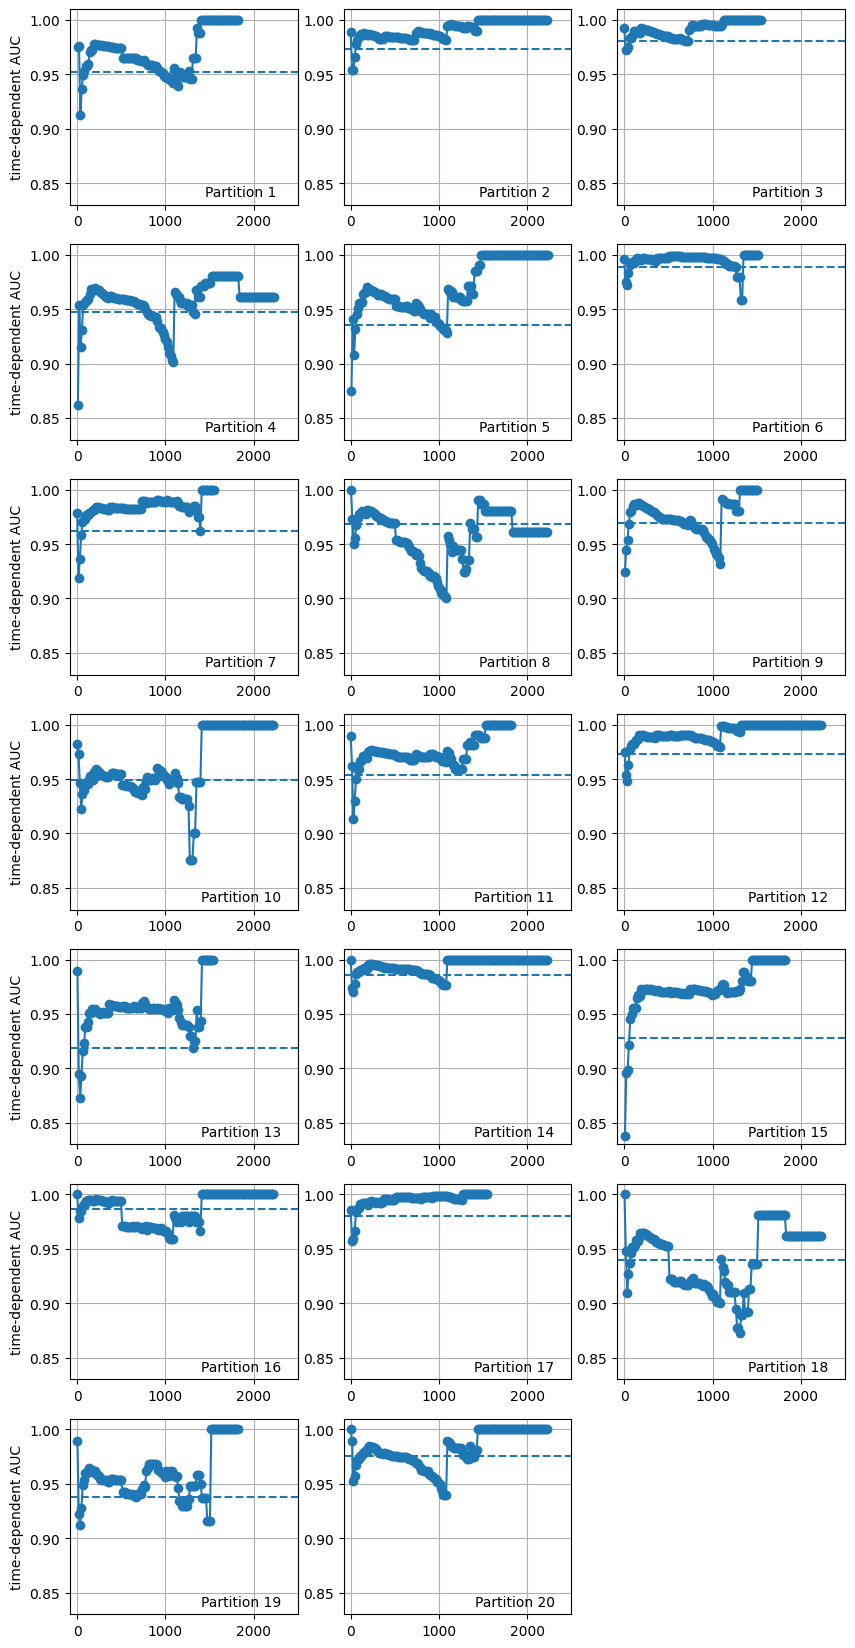

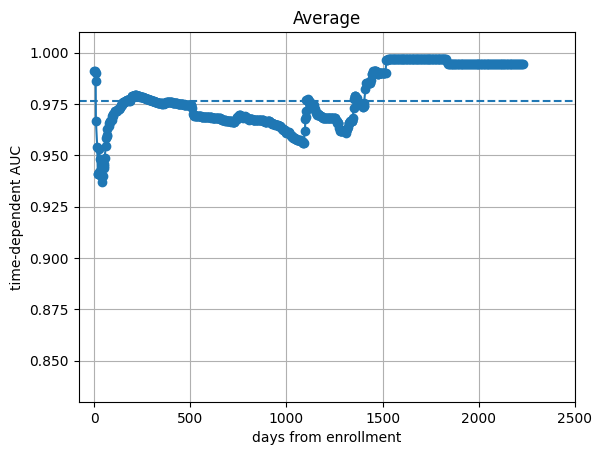


#############################
MODEL: elastic_net_cox
#############################



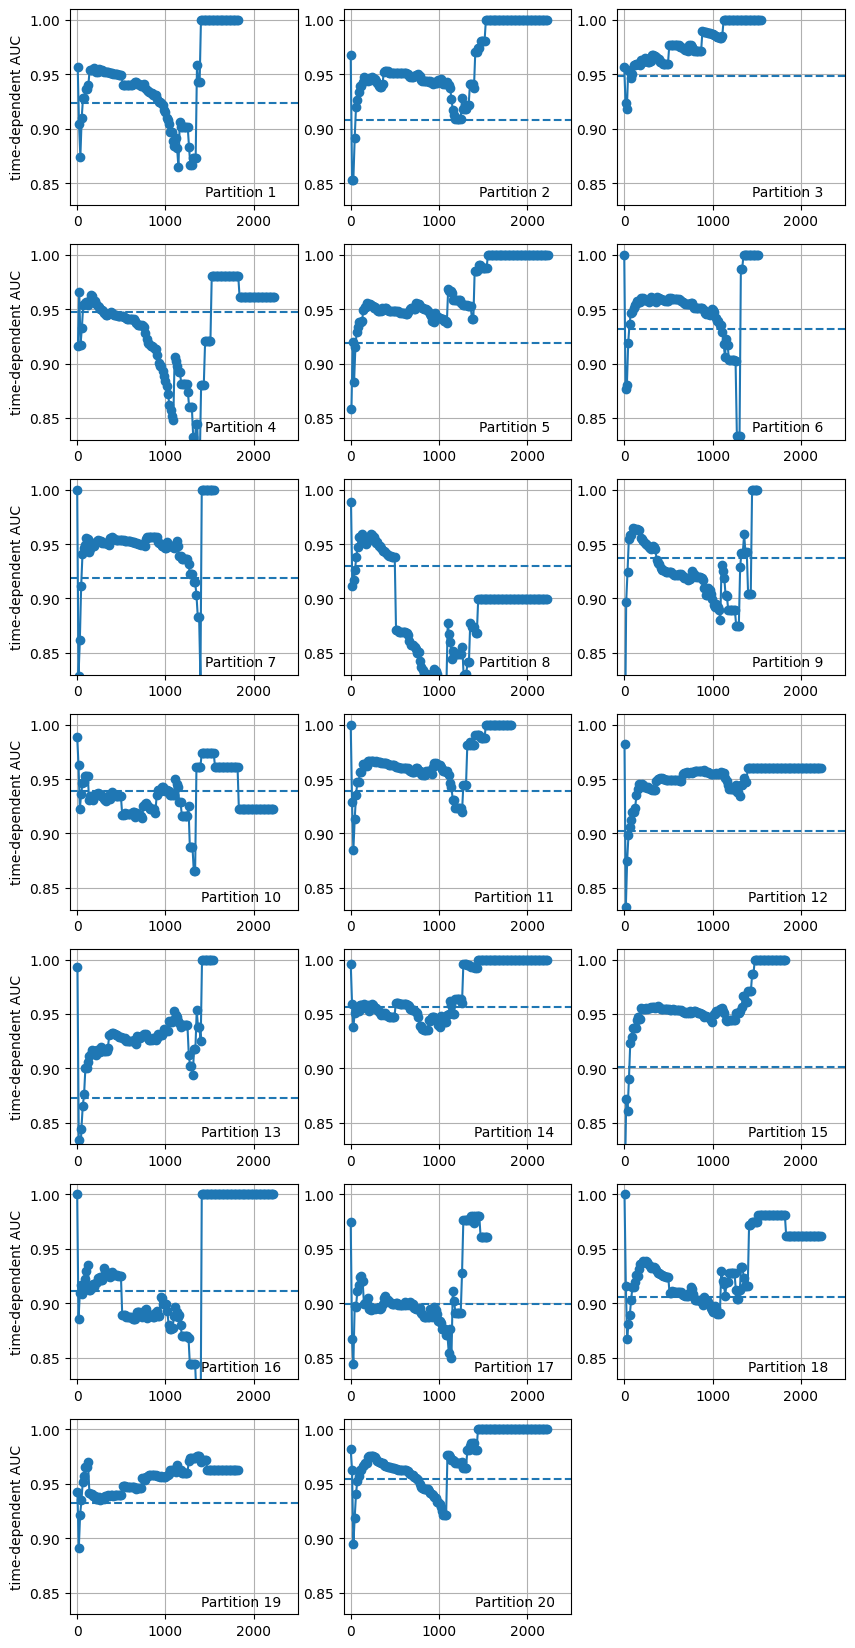

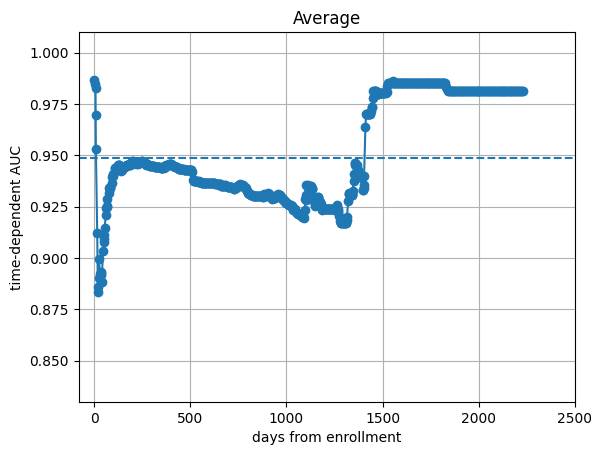


#############################
MODEL: random_survival_forest
#############################



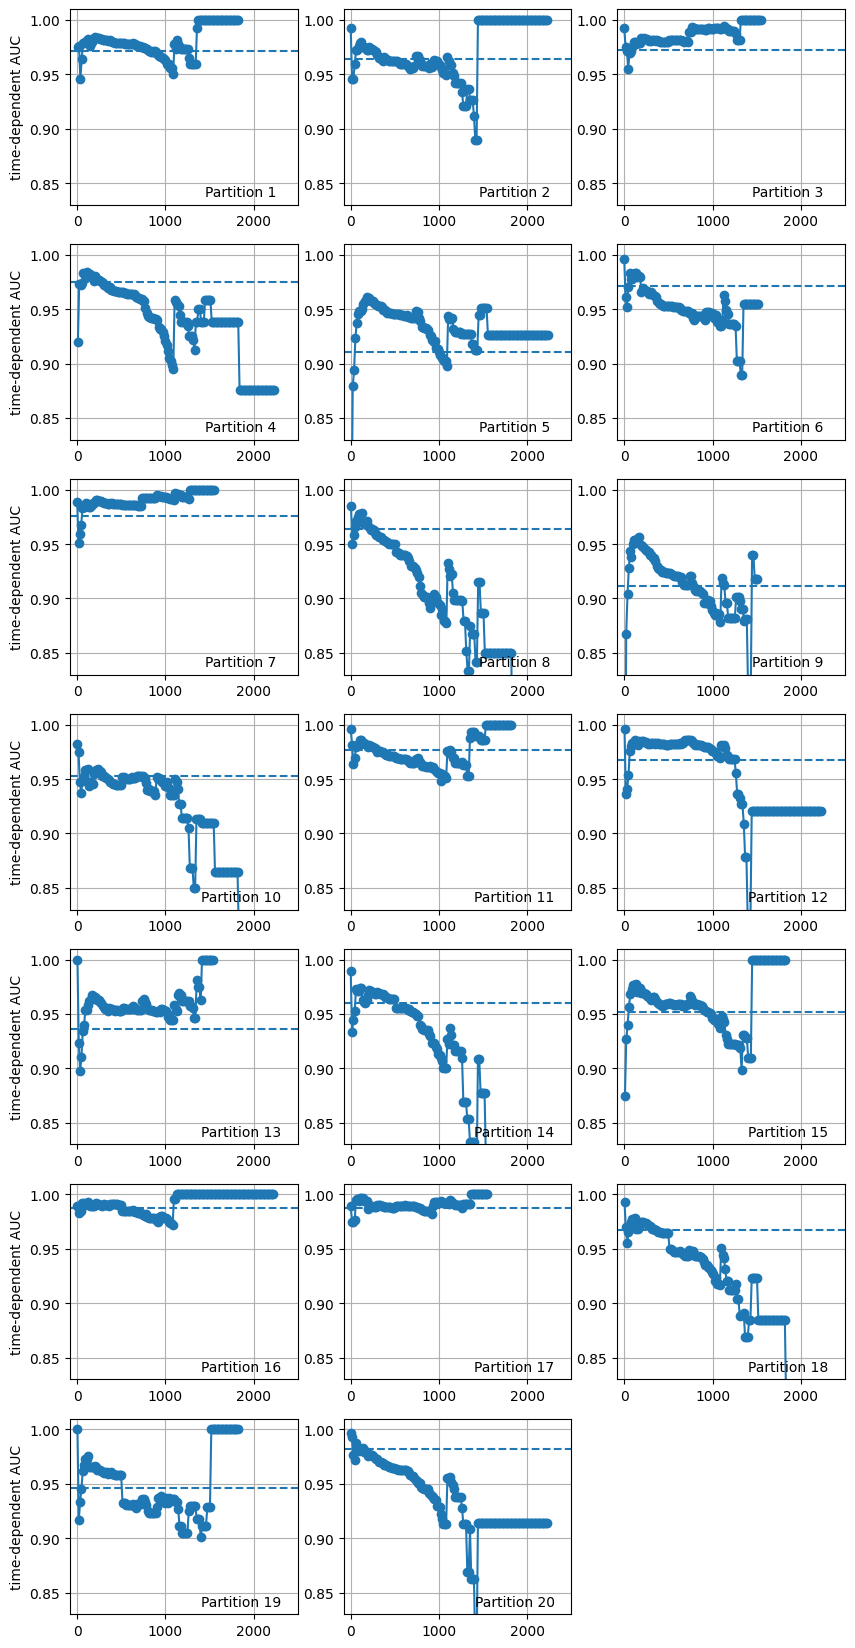

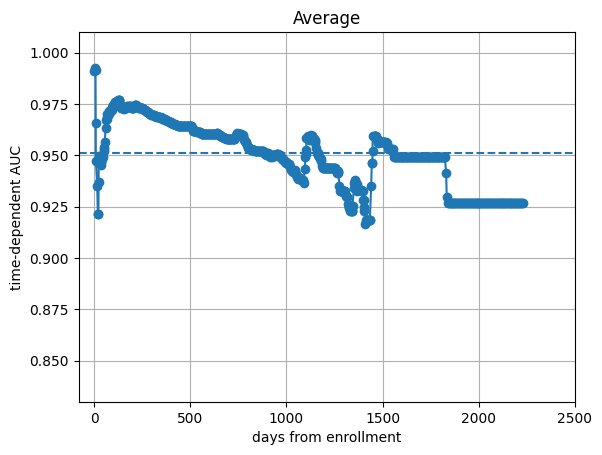


#############################
MODEL: gradient_boosting
#############################



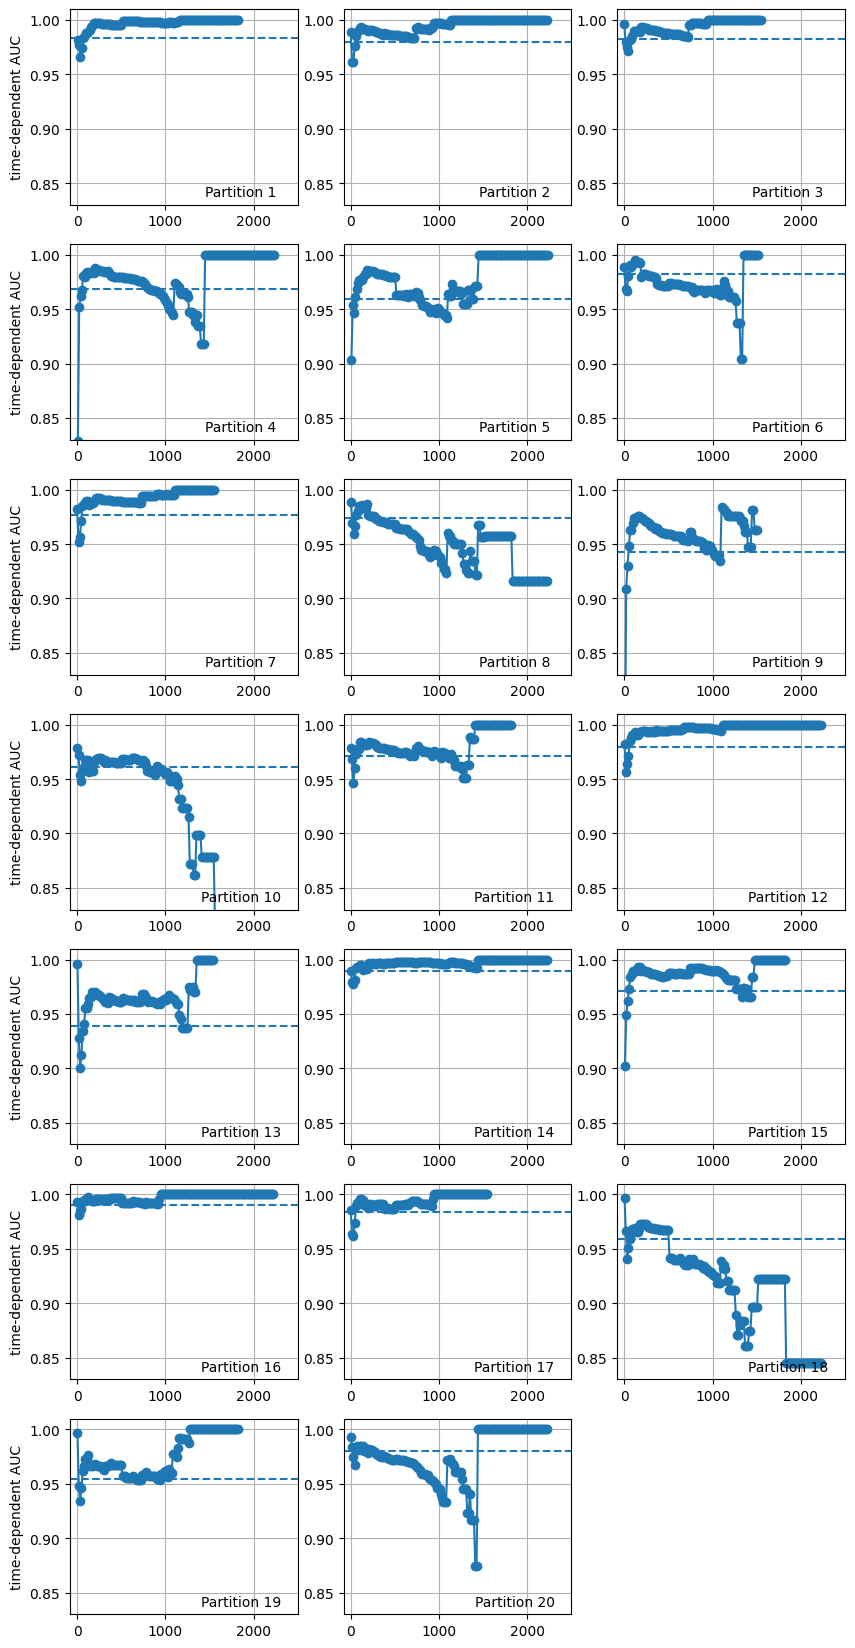

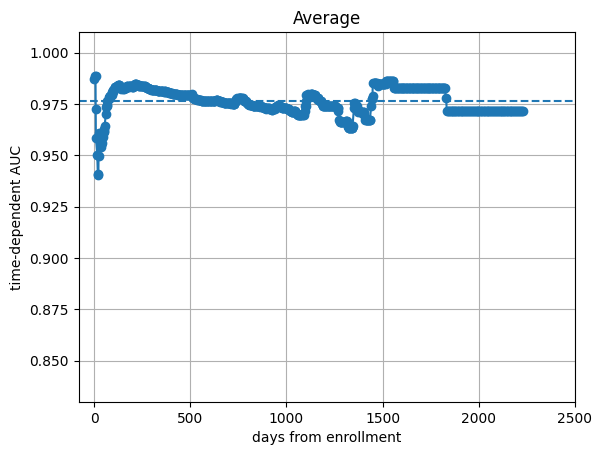

In [12]:
showAUC(models)

In [13]:
from itertools import cycle

def showAUCComparison(models, days=None): 

    n_models = len(models)
    n_subplots = n_models+1
    
    plt.figure(figsize=(15, 20))
    if days==None: 
        plt.suptitle('Comparative time-dependent AUC', y=0.92, fontsize=14)
    else: 
        plt.suptitle(f'Comparative time-dependent AUC ({days} days)', y=0.92, fontsize=14)
        
    cycol = cycle('bgrcmk')
    
    final_comparison = []
    
    for i, model in enumerate(models): 
        scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
        
        times = scores['times']
        aucs = scores['auc']
        
        plt.subplot(int(n_subplots/2)+1, 2, i+1)
        
        new_times = []
        new_aucs = []
        new_mean_aucs = []
        for (auc, time) in zip(aucs, times): 
            if days==None: 
                new_time = time
            else: 
                new_time = [t for t in time if t<=days]
            new_auc = auc[:len(new_time)]
            new_times.append(new_time)
            new_aucs.append(new_auc)
            new_mean_aucs.append(sum(new_auc)/(len(new_auc)))
            
            plt.plot(new_time, new_auc, marker='o', color=next(cycol), alpha=0.05)
            plt.ylim([0.83, 1.01])
            
        final_comparison.append(new_mean_aucs)
            
        mean_times, mean_auc = calculateMeanAUC(new_times, new_aucs)
        mean_mean_auc = sum(mean_auc)/len(mean_auc)
        
        plt.plot(mean_times, mean_auc, marker='o', color='black')
        plt.axhline(mean_mean_auc, linestyle='--')
        
        if i in (n_subplots-3, n_subplots-2): 
            plt.xlabel('days from enrollment')
        if i%2==0: 
            plt.ylabel('time-dependent AUC')
        plt.xlim([-10, days])
        plt.grid(True)
        plt.title(model)
        
        
    plt.figure(figsize=(3, 3))
    
    xs=[]
    for i, d in enumerate(final_comparison): 
        xs.append(np.random.normal(i+1, 0.08, len(d)))  

    alpha_points = 0.1
    for i, (x, d) in enumerate(zip(xs, final_comparison)): 
        for axis, point in zip(x, d): 
            plt.scatter(axis, point, alpha=alpha_points, color=next(cycol))
    
    
    bp = plt.boxplot(final_comparison, labels=models, showfliers=False)
    plt.setp(bp['medians'], color='black', linestyle='--')
    plt.grid(True)
    if days==None: 
        plt.title('Average time-dependent AUC comparison')
    else: 
        plt.title(f'Average time-dependent AUC comparison ({days} days)')
    plt.xticks(rotation=30, ha='right')
    plt.ylabel('Mean time-dependent AUC')
    plt.show()
    
        

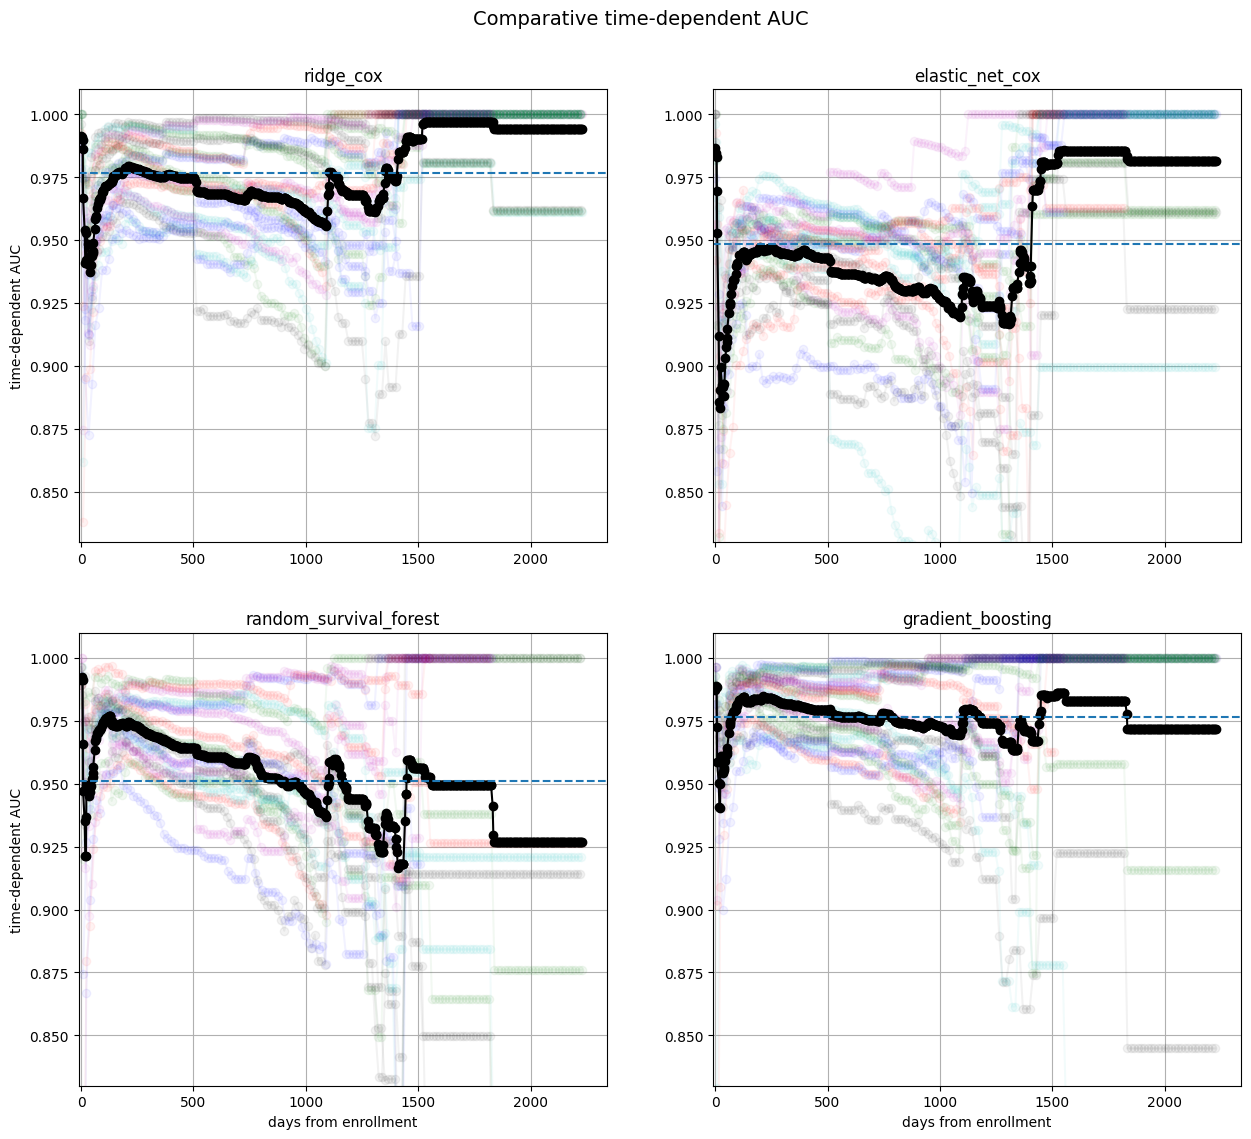

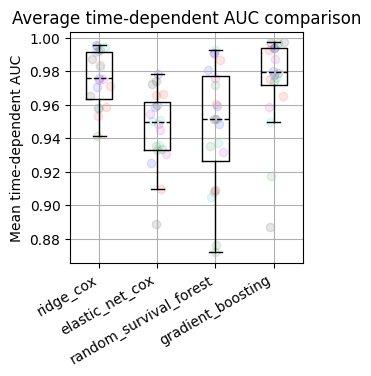

In [14]:
showAUCComparison(models)

## Comparison with only best 20 features

In [11]:
models = ['ridge_cox', 'elastic_net_cox', 'random_survival_forest', 'gradient_boosting']

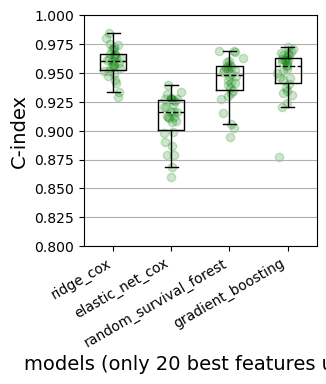

In [12]:
showCindexComparison(models, only_best_features=True)

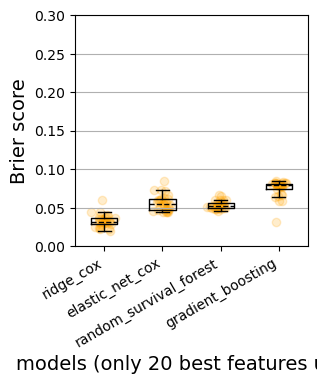

In [13]:
showBrierComparison(models, only_best_features=True)

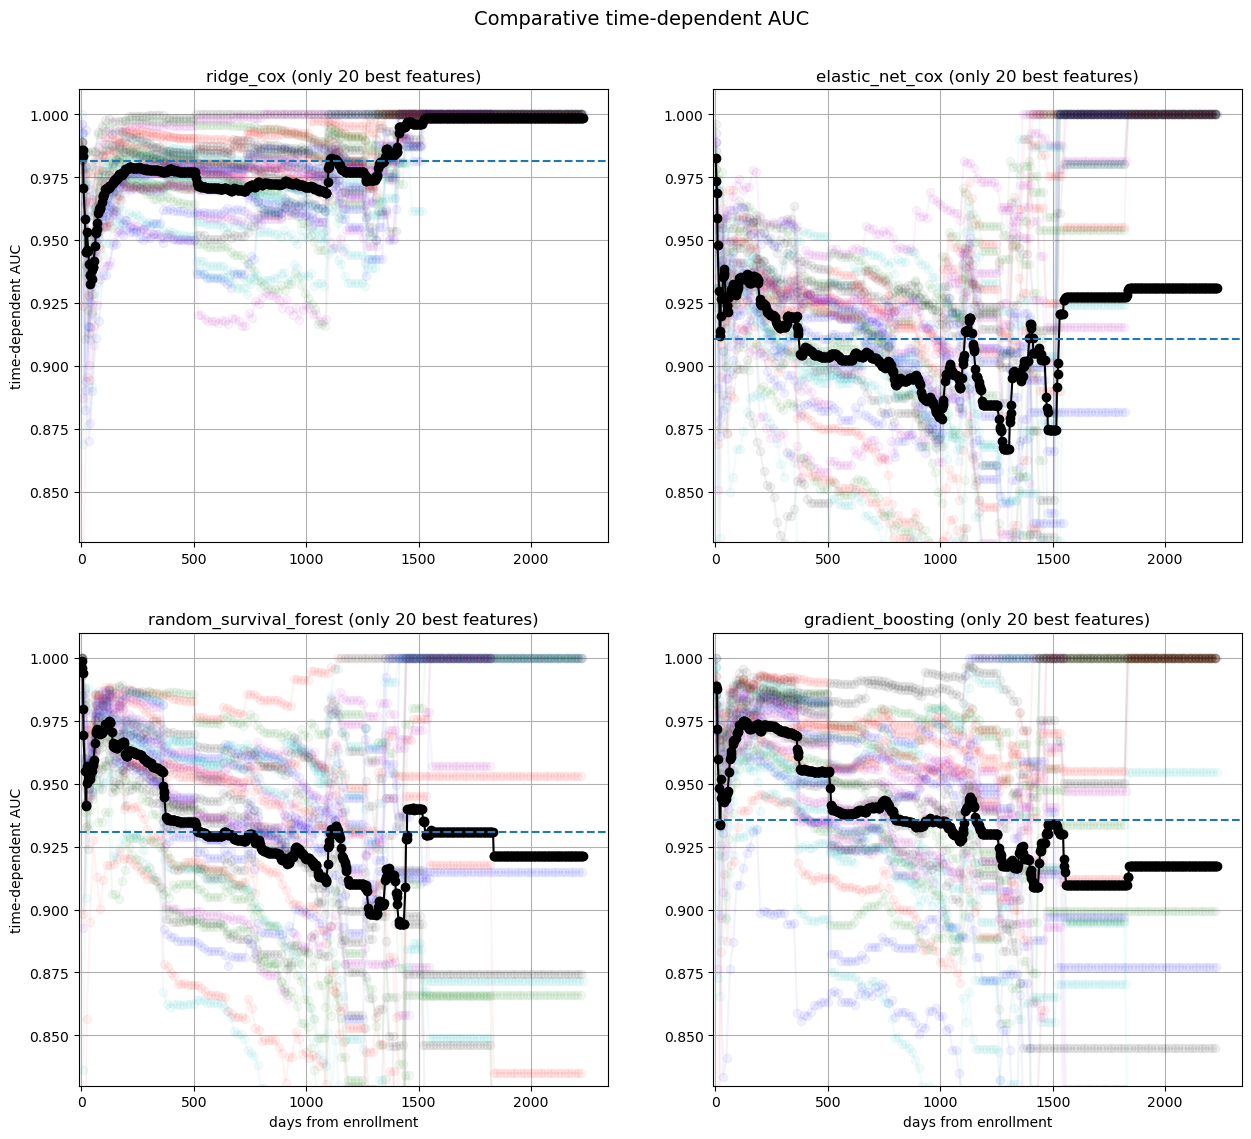

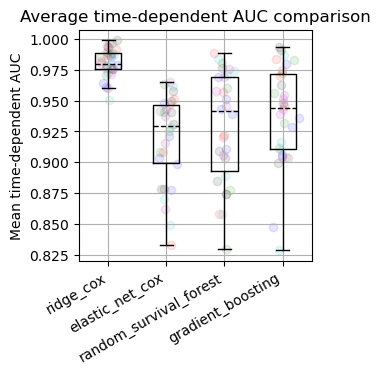

In [12]:
showAUCComparison(models, only_best_features=True)